# True vs Fake News Text Classification

## 3.1 Text Preprocessing, Tokenization, and Sequence Padding:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Required Libraries:

In [ ]:
# Import libraries for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Word cloud for data visualization
from wordcloud import WordCloud


# Regular expressions and string handling
import re
import string

# Natural Language Toolkit (NLTK) for text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK resources
nltk.download('punkt')           # Tokenizer models
nltk.download('punkt_tab')
nltk.download('stopwords')       # Stopword list
nltk.download('wordnet')         # Lemmatizer dictionary
nltk.download('omw-1.4')         # Lemmatizer wordnet data



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
!pip install -U numpy gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 18.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you

### Load the dataset:

In [ ]:
# Load the dataset
file_path = '/content/drive/MyDrive/AI ML/10.True vs. Fake News Dataset/truevsfakenews.csv'
data = pd.read_csv(file_path)
data.head()

,text,label
0,WASHINGTON (Reuters) - The Republican and Demo...,true
1,Women should get as far away from Oklahoma as ...,fake
2,Another huge crowd of Americans tuned in last ...,fake
3,Donald Trump is desperate to stop the investig...,fake
4,"(Reuters) - Planned Parenthood, the U.S. medic...",true


### Clean the text:

In [ ]:
# Drop missing values
data = data[['text', 'label']].dropna()

# Normalize labels to lowercase
data['label'] = data['label'].str.lower()

#### Define Preprocessing Function

In [ ]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Contraction mapping
contractions_dict = {
    "don't": "do not", "doesn't": "does not", "didn't": "did not",
    "can't": "cannot", "won't": "will not", "shouldn't": "should not",
    "isn't": "is not", "aren't": "are not", "wasn't": "was not",
    "weren't": "were not", "hasn't": "has not", "haven't": "have not",
    "hadn't": "had not", "mightn't": "might not", "mustn't": "must not",
    "i'm": "i am", "you're": "you are", "he's": "he is", "she's": "she is",
    "it's": "it is", "we're": "we are", "they're": "they are",
    "i've": "i have", "you've": "you have", "we've": "we have",
    "they've": "they have", "i'll": "i will", "you'll": "you will",
    "he'll": "he will", "she'll": "she will", "we'll": "we will",
    "they'll": "they will"
}

# Compile regex pattern for contractions
contraction_pattern = re.compile(
    r'\b({})\b'.format('|'.join(re.escape(k) for k in contractions_dict.keys())),
    flags=re.IGNORECASE
)

# Function to fix Unicode apostrophe replacements like â€™
def fix_unicode_artifacts(text):
    # Replace common Unicode misinterpretations
    text = text.replace("â€™", "'") \
              .replace("â€œ", "“") \
              .replace("â€", "”") \
              .replace("â€˜", "‘") \
              .replace("â€“", "–") \
              .replace("â€”", "—") \
              .replace("â‚¬", "€") \
              .replace("Â", "")  # Removes stray Â characters
    return text

# Expand contractions
def expand_contractions(text):
    def replace(match):
        word = match.group(0)
        return contractions_dict.get(word.lower(), word)
    return contraction_pattern.sub(replace, text)

# Full preprocessing function
def preprocess_text(text):
    # Step 1: Fix Unicode artifacts
    text = fix_unicode_artifacts(text)

    # Step 2: Lowercase
    text = text.lower()

    # Step 3: Expand contractions
    text = expand_contractions(text)

    # Step 4: Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Step 5: Remove @mentions and #hashtags
    text = re.sub(r'@\w+|#', '', text)

    # Step 6: Remove punctuation (except apostrophes inside words)
    text = re.sub(r'[^\w\s\']', '', text)

    # Step 7: Remove numbers
    text = re.sub(r'\d+', '', text)

    # Step 8: Tokenize and remove stopwords
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

In [ ]:
# Sample raw text
sample_text = [
    "TBILISI (Reuters) - The Trump Organization pulled out of a $250-million real estate project in ex-Soviet Georgia to avoid a potential conflict with Donald Trumpâ€™s role as president, Trumpâ€™s former business partner in the project told Reuters. The Trump Organization declined to comment on the assertion that it quit the project due to conflict-of-interest concerns, and the Trump transition team did not respond to a request for comment. Since winning election as U.S. president, Donald Trump has said he would take steps to ensure he had no conflict of interests with his business. However, he has given few details on how he will do that. Trump planned to give his brand name to Georgian developer Silk Road Group, to build a 47-storey residential tower in the Georgian Black Sea resort of Batumi, a plan he had announced during his visit to the South Caucasus country in April 2012. SRG and the Trump Organization announced their joint decision to terminate the project last week, but did not elaborate on the reasons.  â€œThe only reason (for project termination) was that Mr. Trump was elected as the U.S. president and could not continue business abroad as it would pose a conflict of interest,â€ Giorgi Ramishvili, SRG head, told Reuters in an interview. â€œI appreciate that the Trump Organization said in the statement that it had continued to hold our company and Georgia in the highest regard.â€ Federal law does not prohibit the presidentâ€™s involvement in private business while in office, even though lawmakers and executive branch officials are subject to conflict-of-interest rules. Nevertheless, Trump has come under pressure from Democrats, and some of his Republican allies, to avoid any conflict of interests. Trump has said he plans to transfer control of his businesses to his oldest three children. Georgia will present the White House with a thorny foreign policy problem. A close U.S. ally seeking membership of NATO, it accuses Russia of propping up separatists in two breakaway regions on its territory. That could complicate Trumpâ€™s drive for friendlier relations with Russian President Vladimir Putin. Asked to comment on the reasons for pulling out of the Georgia project, the Trump Organization sent Reuters a joint statement with SRG announcing the decision but not giving a reason. Alan Garten, the Trump Organizationâ€™s general counsel, said the organization stood by its statement and declined to comment on Ramishviliâ€™s assertion the deal was cancelled due to conflict-of-interest concerns. The Trump transition team, which typically defers to the Trump Organization on business issues, did not respond to a request for comment. The Trump Organization has canceled licensing deals in  some other countries, including Brazil and Azerbaijan, but has not publicly cited conflict of interest concerns as the reason for those decisions. Ramishvili said his company, one of the largest private investment companies in the South Caucasus, would still go ahead with the Batumi tower project. He said his company was ready to invest not less than the $250 million that was originally planned. â€œIt wonâ€™t have Trumpâ€™s name, but it may be called the Fifth Avenue Tower as it will look similar to the Trump Tower in New York,â€ Ramishvili said. Ramishvili said he believed Trump would â€œkeep Georgia on his mindâ€ during his presidency. â€œIâ€™m sure that President Trump will always remember positive emotions that he had during his visit to our country, when he dubbed Georgia as one of the amazing places in the world,â€ Ramishvili said. â€œIâ€™m happy that Iâ€™ve brought this iconic figure to Georgia and Iâ€™m sure that he will be a great president.â€ ",
]

# Apply cleaning
for i, text in enumerate(sample_text):
    cleaned = preprocess_text(text)
    print("Original :", text)
    print("Cleaned  :", cleaned)
    print()


Original : TBILISI (Reuters) - The Trump Organization pulled out of a $250-million real estate project in ex-Soviet Georgia to avoid a potential conflict with Donald Trumpâ€™s role as president, Trumpâ€™s former business partner in the project told Reuters. The Trump Organization declined to comment on the assertion that it quit the project due to conflict-of-interest concerns, and the Trump transition team did not respond to a request for comment. Since winning election as U.S. president, Donald Trump has said he would take steps to ensure he had no conflict of interests with his business. However, he has given few details on how he will do that. Trump planned to give his brand name to Georgian developer Silk Road Group, to build a 47-storey residential tower in the Georgian Black Sea resort of Batumi, a plan he had announced during his visit to the South Caucasus country in April 2012. SRG and the Trump Organization announced their joint decision to terminate the project last week, b

### Apply Preprocessing to Dataset

In [ ]:
# Apply preprocessing
data['cleaned_text'] = data['text'].apply(preprocess_text)

### Visualize Cleaned Data Using Word Cloud

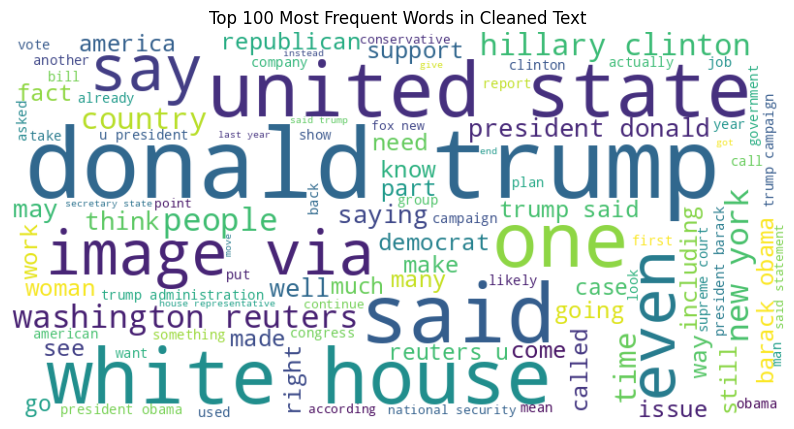

In [ ]:
# Generate word cloud from cleaned text
all_words = ' '.join(data['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 Most Frequent Words in Cleaned Text')
plt.show()

### Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data['cleaned_text'],
    data['label'],
    test_size=0.2,
    random_state=42,
    stratify=data['label']
)

### Tokenization

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np


# Initialize tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)  # Only fit on training data

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

### Padding Sequences Based on 95th Percentile

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Calculate sequence lengths
seq_lengths = [len(seq) for seq in X_train_seq]

# Get 95th percentile of sequence lengths
max_len = int(np.percentile(seq_lengths, 95))
print(f"Padding sequences to maximum length: {max_len}")

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Check shapes
print(f"\nTraining data shape after padding: {X_train_pad.shape}")
print(f"Testing data shape after padding: {X_test_pad.shape}")

Padding sequences to maximum length: 494

Training data shape after padding: (16000, 494)
Testing data shape after padding: (4000, 494)


#### Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode string labels to integers
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Get number of classes (should be 2 for binary classification)
num_classes = len(le.classes_)  # Output: 2
print(f"Number of classes: {num_classes}")
print(f"Class names: {list(le.classes_)}")

Number of classes: 2
Class names: ['fake', 'true']


## 3.2 Model Building and Training

### Import Required Libraries

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.initializers import Constant
import gensim.downloader as api
import numpy as np

### MODEL 1: Simple RNN with Trainable Embedding

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model_rnn = Sequential()

# Embedding Layer
model_rnn.add(Embedding(
    input_dim=10000,
    output_dim=128,
    input_length=max_len
))

# Recurrent Layer
model_rnn.add(SimpleRNN(units=64))

# Output Layer
model_rnn.add(Dense(1, activation='sigmoid'))

# Compile Model
model_rnn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Build the model manually by specifying the input shape
model_rnn.build(input_shape=(None, X_train_pad.shape[1]))

# Print Model Summary
model_rnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 494, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,292,417 (4.93 MB)

 Trainable params: 1,292,417 (4.93 MB)

 Non-trainable params: 0 (0.00 B)

### MODEL 2: LSTM with Trainable Embedding

In [ ]:
from tensorflow.keras.layers import LSTM

model_lstm = Sequential()

# Embedding Layer
model_lstm.add(Embedding(
    input_dim=10000,
    output_dim=128,
    input_length=max_len
))

# LSTM Layer
model_lstm.add(LSTM(units=64))

# Output Layer
model_lstm.add(Dense(1, activation='sigmoid'))

# Compile
model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Build the model
model_lstm.build(input_shape=(None, X_train_pad.shape[1]))

model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 494, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

### MODEL 3: LSTM with Pretrained Word2Vec Embeddings

#### Download and load a pretrained Word2Vec model

In [ ]:
embedding_model = api.load("glove-wiki-gigaword-50")  # 50-dimensional vectors
embedding_dim = 50

[==================================================] 100.0% 66.0/66.0MB downloaded


#### Create Embedding Matrix

In [ ]:
vocab_size = min(len(tokenizer.word_index) + 1, 11000)  # Cap at 10,000 words
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i >= 10000:
        continue
    if word in embedding_model:
        embedding_vector = embedding_model[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### Define LSTM Model Using Word2Vec Embeddings

In [ ]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import Constant

model_lstm_word2vec = Sequential()

# Embedding Layer with Pretrained Weights
model_lstm_word2vec.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    input_length=max_len,
    embeddings_initializer=Constant(embedding_matrix),  # Use pretrained weights
    trainable=False  # Freeze embeddings unless fine-tuning
))

# LSTM Layer
model_lstm_word2vec.add(LSTM(units=64))

# Output Layer
model_lstm_word2vec.add(Dense(1, activation='sigmoid'))

# Compile
model_lstm_word2vec.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Build the model manually to initialize layers
model_lstm_word2vec.build(input_shape=(None, X_train_pad.shape[1]))

model_lstm_word2vec.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 494, 50)        │       550,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 579,505 (2.21 MB)

 Trainable params: 29,505 (115.25 KB)

 Non-trainable params: 550,000 (2.10 MB)

## 3.3 Model Training and Evaluation:

### Define Callbacks

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

### Train Simple RNN

In [ ]:
history_rnn = model_rnn.fit(
    X_train_pad,
    y_train_enc,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.5266 - loss: 0.6704 - val_accuracy: 0.4956 - val_loss: 0.6858
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.5368 - loss: 0.6604 - val_accuracy: 0.4959 - val_loss: 0.6859
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.5373 - loss: 0.6603 - val_accuracy: 0.5344 - val_loss: 0.6848
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.5311 - loss: 0.6590 - val_accuracy: 0.5312 - val_loss: 0.6909
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.5356 - loss: 0.6598 - val_accuracy: 0.5316 - val_loss: 0.6865
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.5370 - loss: 0.6603 - val_accuracy: 0.4906 - val_loss: 0.6884
Epoch 7/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.5371 - loss: 0.6605 - val_accuracy: 0.5319 - val_loss: 0.6877
Epoch 8/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.5405 - loss: 0.6593 - 

### Train LSTM

In [ ]:
history_lstm = model_lstm.fit(
    X_train_pad,
    y_train_enc,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.5334 - loss: 0.6899 - val_accuracy: 0.5456 - val_loss: 0.6722
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5387 - loss: 0.6716 - val_accuracy: 0.5000 - val_loss: 0.6690
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5617 - loss: 0.6618 - val_accuracy: 0.7881 - val_loss: 0.4676
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8980 - loss: 0.3155 - val_accuracy: 0.9684 - val_loss: 0.1089
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9870 - loss: 0.0569 - val_accuracy: 0.9669 - val_loss: 0.1048
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9923 - loss: 0.0377 - val_accuracy: 0.9787 - val_loss: 0.0870
Epoch 7/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9956 - loss: 0.0211 - val_accuracy: 0.9816 - val_loss: 0.0630
Epoch 8/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9985 - loss: 0.0067 - val_a

### Train LSTM with Word2Vec

In [ ]:
history_word2vec = model_lstm_word2vec.fit(
    X_train_pad,
    y_train_enc,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.5689 - loss: 0.6584 - val_accuracy: 0.6194 - val_loss: 0.5873
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.7218 - loss: 0.4937 - val_accuracy: 0.9328 - val_loss: 0.2881
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.7648 - loss: 0.4771 - val_accuracy: 0.5534 - val_loss: 0.6689
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6393 - loss: 0.5924 - val_accuracy: 0.9137 - val_loss: 0.2593
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9129 - loss: 0.2562 - val_accuracy: 0.9331 - val_loss: 0.2244
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9375 - loss: 0.2140 - val_accuracy: 0.9344 - val_loss: 0.2367
Epoch 7/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9227 - loss: 0.2494 - val_accuracy: 0.9247 - val_loss: 0.2353
Epoch 8/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9223 - loss: 0.2388 - val_a

### Plot Training vs Validation Accuracy & Loss

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Plot Each Model's History

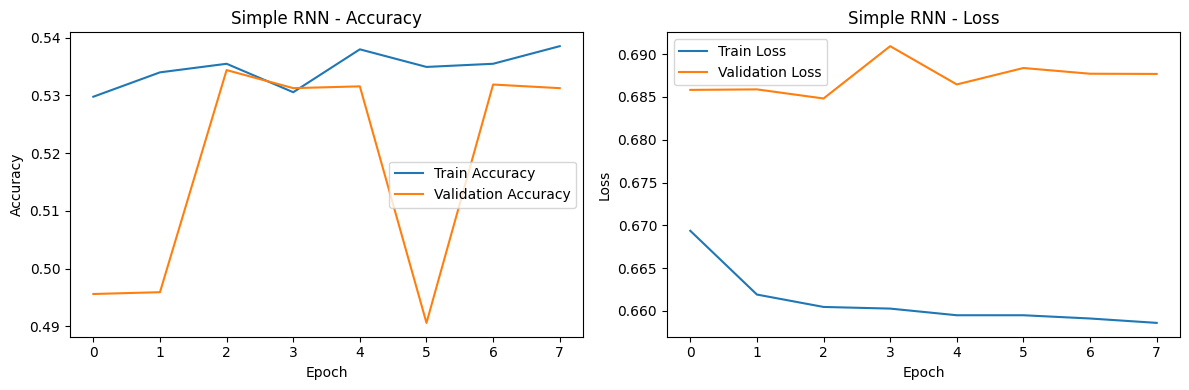

In [ ]:
plot_history(history_rnn, "Simple RNN")

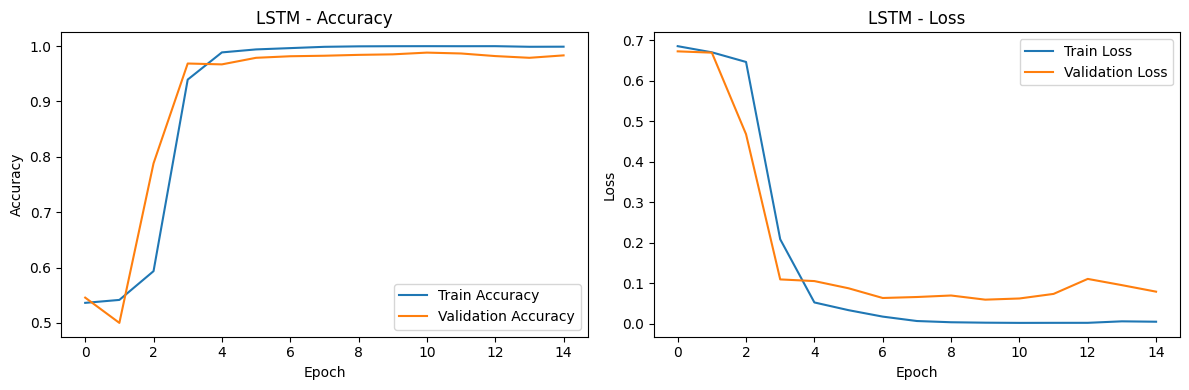

In [ ]:
plot_history(history_lstm, "LSTM")

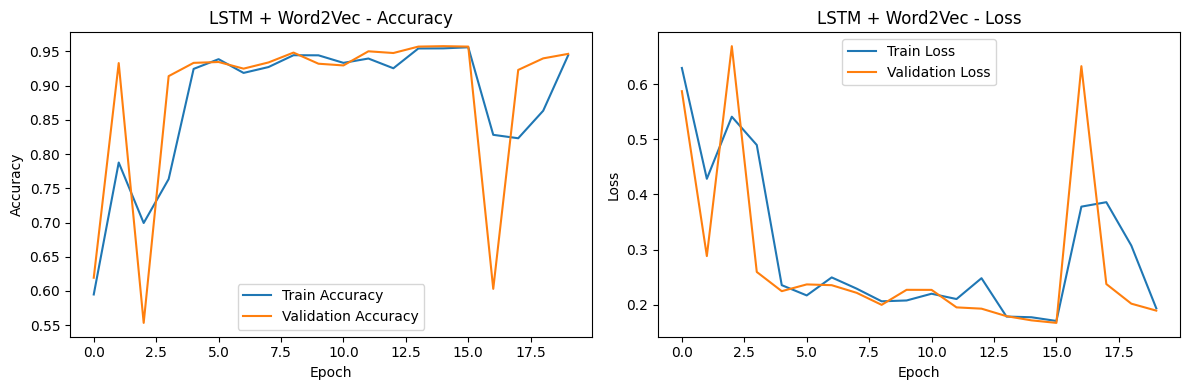

In [ ]:
plot_history(history_word2vec, "LSTM + Word2Vec")

## Evaluate Models on Test Set

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    # Binary classification: threshold at 0.5
    y_pred_classes = (y_pred > 0.5).astype(int).flatten()

    acc = accuracy_score(y_test, y_pred_classes)
    print(f"\n{model_name} - Test Accuracy: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    print(f"\nConfusion Matrix:\n{cm}")

    # Classification Report
    cr = classification_report(y_test, y_pred_classes, target_names=le.classes_)
    print(f"\nClassification Report:\n{cr}")


### Run Evaluation for All Models

In [ ]:
evaluate_model(model_rnn, X_test_pad, y_test_enc, "Simple RNN")

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step

Simple RNN - Test Accuracy: 0.5333

Confusion Matrix:
[[1972   28]
 [1839  161]]

Classification Report:
              precision    recall  f1-score   support

        fake       0.52      0.99      0.68      2000
        true       0.85      0.08      0.15      2000

    accuracy                           0.53      4000
   macro avg       0.68      0.53      0.41      4000
weighted avg       0.68      0.53      0.41      4000



In [ ]:
evaluate_model(model_lstm, X_test_pad, y_test_enc, "LSTM")

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

LSTM - Test Accuracy: 0.9815

Confusion Matrix:
[[1957   43]
 [  31 1969]]

Classification Report:
              precision    recall  f1-score   support

        fake       0.98      0.98      0.98      2000
        true       0.98      0.98      0.98      2000

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000



In [ ]:
evaluate_model(model_lstm_word2vec, X_test_pad, y_test_enc, "LSTM + Word2Vec")

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

LSTM + Word2Vec - Test Accuracy: 0.9483

Confusion Matrix:
[[1821  179]
 [  28 1972]]

Classification Report:
              precision    recall  f1-score   support

        fake       0.98      0.91      0.95      2000
        true       0.92      0.99      0.95      2000

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



### Compare Model Performances

In [ ]:
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score

table = PrettyTable()
table.field_names = ["Model", "Test Accuracy"]

for model, name in zip(
    [model_rnn, model_lstm, model_lstm_word2vec],
    ["Simple RNN", "LSTM", "LSTM + Word2Vec"]
):
    y_pred = model.predict(X_test_pad)

    # For binary classification using sigmoid output
    y_pred_classes = (y_pred > 0.5).astype(int).flatten()

    acc = accuracy_score(y_test_enc, y_pred_classes)
    table.add_row([name, f"{acc:.4f}"])

print("\nModel Comparison:")
print(table)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Model Comparison:
+-----------------+---------------+
|      Model      | Test Accuracy |
+-----------------+---------------+
|    Simple RNN   |     0.5333    |
|       LSTM      |     0.9815    |
| LSTM + Word2Vec |     0.9483    |
+-----------------+---------------+


### Save Models

In [ ]:
# Save Simple RNN Model
model_rnn.save("/content/drive/MyDrive/AI ML/simple_rnn_model.h5")

In [ ]:
# Save LSTM Model
model_lstm.save("/content/drive/MyDrive/AI ML/lstm_model.h5")

In [ ]:
# Save LSTM + Word2Vec Model
model_lstm_word2vec.save("/content/drive/MyDrive/AI ML/lstm_word2vec_model.h5")

### Load Required Libraries again

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 108.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.4 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Ensure NLTK resources are available
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Redefine Preprocessing Function

In [ ]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Improved contraction mapping
contractions_dict = {
    "don't": "do not", "doesn't": "does not", "didn't": "did not",
    "can't": "cannot", "won't": "will not", "shouldn't": "should not",
    "isn't": "is not", "aren't": "are not", "wasn't": "was not",
    "weren't": "were not", "hasn't": "has not", "haven't": "have not",
    "hadn't": "had not", "mightn't": "might not", "mustn't": "must not",
    "i'm": "i am", "you're": "you are", "he's": "he is", "she's": "she is",
    "it's": "it is", "we're": "we are", "they're": "they are",
    "i've": "i have", "you've": "you have", "we've": "we have",
    "they've": "they have", "i'll": "i will", "you'll": "you will",
    "he'll": "he will", "she'll": "she will", "we'll": "we will",
    "they'll": "they will"
}

# Compile regex pattern for contractions
contraction_pattern = re.compile(
    r'\b({})\b'.format('|'.join(re.escape(k) for k in contractions_dict.keys())),
    flags=re.IGNORECASE
)

# Fix Unicode artifacts
def fix_unicode_artifacts(text):
    return text.replace("â€™", "'").replace("â€œ", "“").replace("â€", "”").replace("â€“", "–").replace("Â", "")

# Expand contractions
def expand_contractions(text):
    def replace(match):
        word = match.group(0).lower()
        return contractions_dict.get(word, word)
    return contraction_pattern.sub(replace, text)

# Full preprocessing function
def preprocess_input(text):
    text = fix_unicode_artifacts(text)
    text = text.lower()
    text = expand_contractions(text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+|#', '', text)
    text = re.sub(r'[^\w\s\']', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

### Load Saved Models

In [ ]:
from tensorflow.keras.models import load_model

# Ask user for the directory where models are saved
save_path = input("Enter the directory path where your models are saved (e.g., /content/drive/MyDrive/AI ML): ")

# Ensure the path doesn't end with a slash for consistency
save_path = save_path.rstrip('/')

# Load models from user-specified path
loaded_rnn = load_model(f"{save_path}/simple_rnn_model.h5")
loaded_lstm = load_model(f"{save_path}/lstm_model.h5")
loaded_lstm_word2vec = load_model(f"{save_path}/lstm_word2vec_model.h5")

print("\n Models loaded successfully!")

Enter the directory path where your models are saved (e.g., /content/drive/MyDrive/AI ML): /content/drive/MyDrive/AI ML



 Models loaded successfully!


### Define Prediction Function

In [ ]:
# Global tokenizer and max_len used during training
global_tokenizer = tokenizer  # Use the one from earlier
global_max_len = X_train_pad.shape[1]

# Label encoder
le_classes = le.classes_  # e.g., ['fake', 'true']

def predict_news(news_text, model_choice):
    # Preprocess input
    cleaned_text = preprocess_input(news_text)

    # Tokenize and pad
    sequence = global_tokenizer.texts_to_sequences([cleaned_text])
    padded_seq = pad_sequences(sequence, maxlen=global_max_len, padding='post', truncating='post')

    # Choose model
    if model_choice == "Simple RNN":
        model = loaded_rnn
    elif model_choice == "LSTM":
        model = loaded_lstm
    else:
        model = loaded_lstm_word2vec

    # Predict
    prediction = model.predict(padded_seq, verbose=0)
    predicted_label = le_classes[np.argmax(prediction)]

    # Return styled HTML output
    if predicted_label == 'true':
        return "<div style='padding:20px; background-color:#d4edda; color:#155724; font-size:20px; border-radius:8px; text-align:center;'>✅ True News</div>"
    else:
        return "<div style='padding:20px; background-color:#f8d7da; color:#721c24; font-size:20px; border-radius:8px; text-align:center;'>❌ Fake News</div>"

### Create Gradio Interface

In [ ]:
# Dropdown for model selection
model_options = ["Simple RNN", "LSTM", "LSTM + Word2Vec"]

# Custom CSS for better styling
custom_css = """
.gradio-container {
    background-color: #f9f9f9;
    font-family: 'Arial';
}
button {
    background-color: #1e90ff;
    color: white;
    border-radius: 8px;
    padding: 10px 20px;
}
"""

# Gradio Interface
demo = gr.Interface(
    fn=predict_news,
    inputs=[
        gr.Textbox(lines=5, placeholder="Enter news article or tweet here...", label="Input Text"),
        gr.Dropdown(choices=model_options, value="LSTM + Word2Vec", label="Select Model")
    ],
    outputs=gr.HTML(label="Prediction Result"),  # <-- Changed from Markdown to HTML
    title="📰 True vs Fake News Classifier",
    description="Classify whether a piece of news is true or fake using RNN, LSTM, or LSTM with Word2Vec embeddings.",
    theme="soft",
    css=custom_css,
    allow_flagging="never"
)

# Launch Gradio App
demo.launch()

/usr/local/lib/python3.11/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8b1163f7202e4f29cb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
